# QA (question&Answering)

For question answering, the first sentence is the question while the second one is the paragraph. The first token is always the [CLS] token while the [SEP] separates the two sentences. 

example: 

              Question                          answer_text

`[CLS] Quanti anni ha Marco? [SEP] Marco é nato nel 1989, dunque quest'anno comprà 30 anni. `


The probability of each word being the start-word is calculated by taking a dot product between the final embedding of the word and the start vector, followed by a softmax over all the words. The word with the highest probability value is considered.

Again we will use the Huggingface library. 



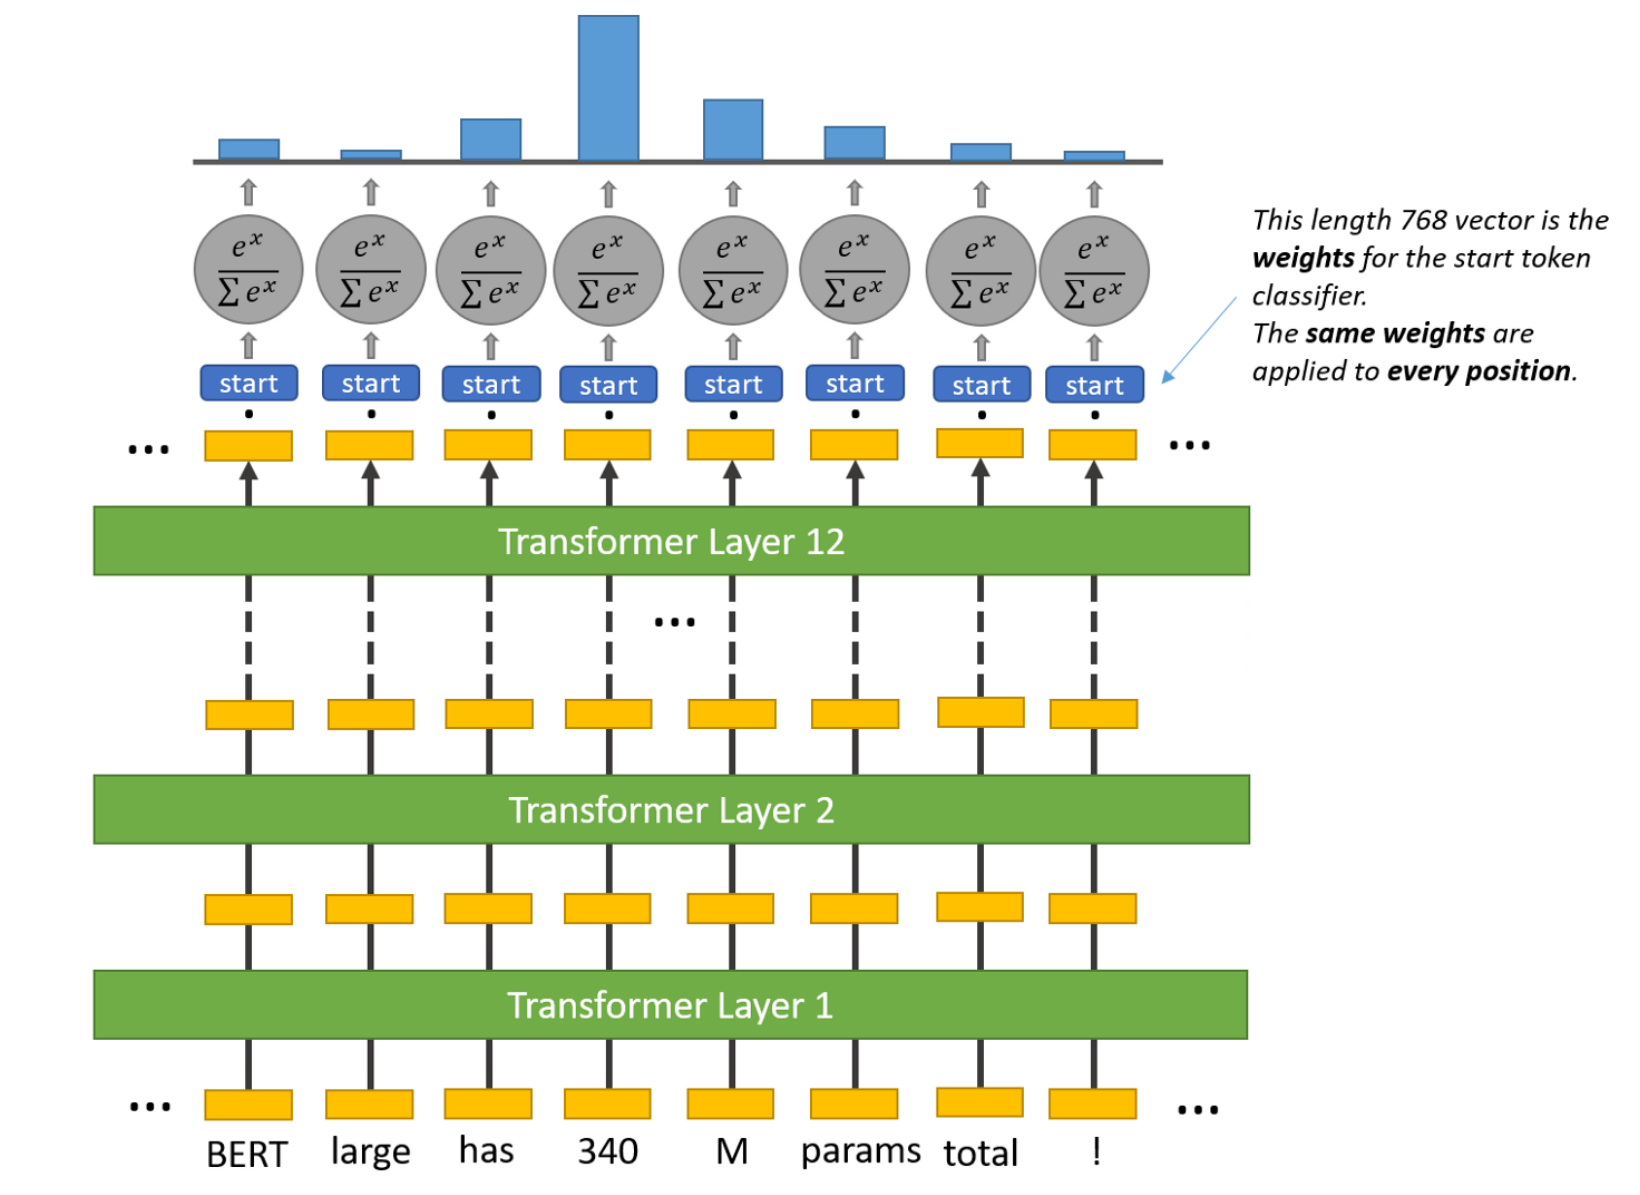


image from : Suman Karanjit

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 7.7 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 61.0 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 895 kB 60.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

#model_name_pretrained = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
model_name_pretrained = 'mrm8488/bert-italian-finedtuned-squadv1-it-alfa' # this model is trained on the SQuAD v1.1, dataset for Italian, https://github.com/crux82/squad-it  

#Model
model = BertForQuestionAnswering.from_pretrained(model_name_pretrained)

#Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name_pretrained)

Before using the model we need to encode the question and the paragraph using the function encode_plus. 

In [ ]:
question = "Dove si trovano le Isole Marshall?"
answer_text = "Facente parte della Micronesia, le Isole Marshall sono un gruppo di atolli e isole situate nel Pacifico, poco a nord dell'equatore."

            
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))


The input has a total of 41 tokens.


In [ ]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    


[CLS]           102
Dove          1,898
si              223
trovano       4,178
le              199
Isole        12,625
Marshall     16,243
?             3,098

[SEP]           103

Face          6,833
##nte         1,696
parte           439
della           213
Micro         6,947
##nes        11,519
##ia            129
,             1,307
le              199
Isole        12,625
Marshall     16,243
sono            288
un              141
gruppo        1,288
di              120
ato          12,320
##lli         1,788
e               126
isole         6,806
situate      19,445
nel             207
Pacifico     13,653
,             1,307
poco          2,131
a               111
nord          2,979
dell            298
'             1,553
equa         30,186
##tore          549
.               697

[SEP]           103



In [ ]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)


In [ ]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids]), return_dict=False) # The segment IDs to differentiate question from answer_text



In [ ]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')


Answer: "Pacifico"


In [ ]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')


Answer: "Pacifico"


Visualize the scores for each word. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)


In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))



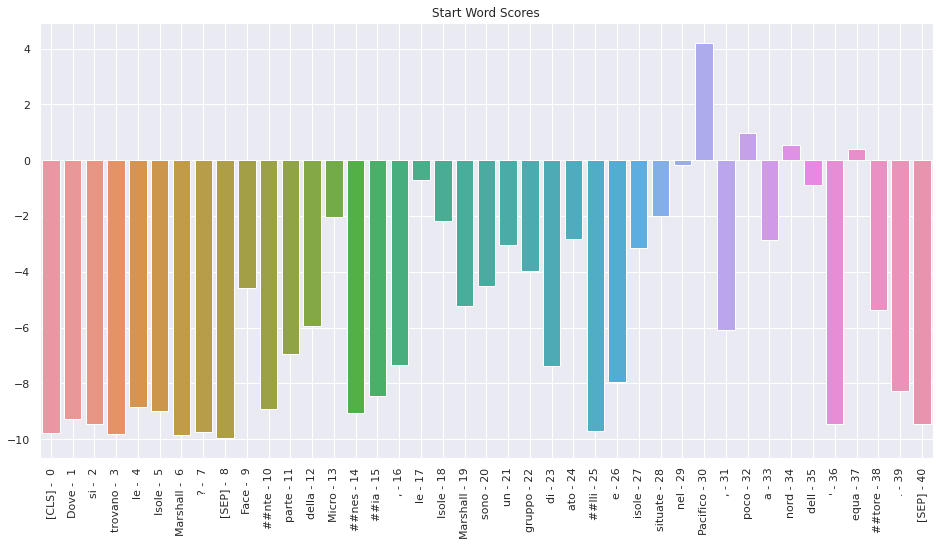

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()


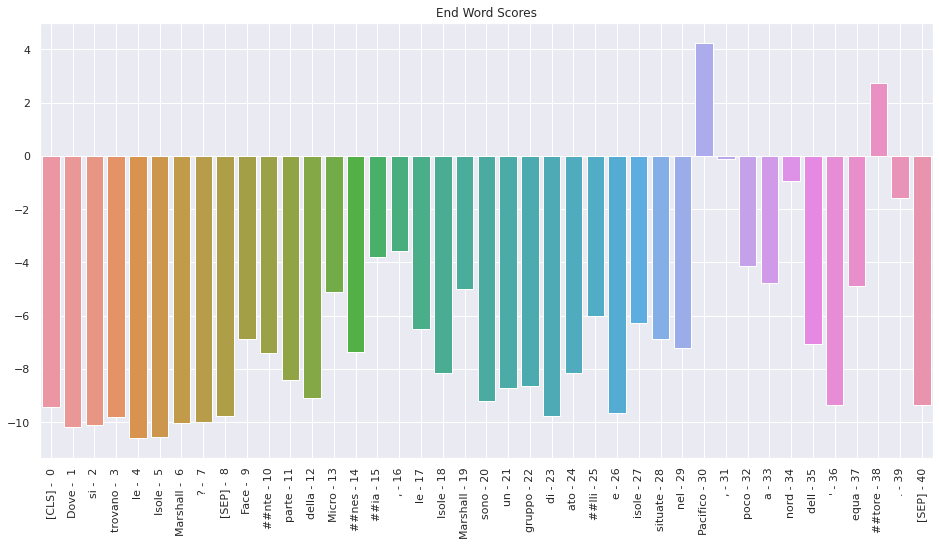

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()


# Fine tuning from pre-trained

In [1]:
# mount the disk in Colab 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 7.3 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
     |████████████████████████████████| 3.3 MB 54.3 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from transformers import AutoTokenizer
# initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')


Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

In [4]:
import os
import requests
import json

def read_squad(path):
    # open JSON file and load intro dictionary
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                # check if we need to be extracting from 'answers' or 'plausible_answers'
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa[access]:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

# execute our read SQuAD function for training and validation sets
train_contexts, train_questions, train_answers = read_squad('drive/MyDrive/Colab Notebooks/NLP course/dataset/train-v2.0.json')

In [5]:
print(train_contexts[0])
print(train_questions[0]) 
print(train_answers[0]) 

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
When did Beyonce start becoming popular?
{'text': 'in the late 1990s', 'answer_start': 269}


In [5]:
N = 2000
train_contexts = train_contexts[:N]
train_questions = train_questions[:N]
train_answers = train_answers[:N]

In [6]:
def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)
        
        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            # this means the answer is off by 1-2 tokens
            for n in [1, 2, 3]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n
                    
        if "answer_end" not in answer:
            answer['answer_end'] = end_idx

# and apply the function to our two answer lists
add_end_idx(train_answers, train_contexts)

In [7]:
from transformers import AutoTokenizer
# initialize the tokenizer
#tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-cased')
# tokenize
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [8]:
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift position until found
        shift = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# apply function to our data
add_token_positions(train_encodings, train_answers)

In [ ]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [9]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# build datasets for both our training and validation sets
train_dataset = SquadDataset(train_encodings)

In [10]:
torch.cuda.empty_cache()

from transformers import (AutoConfig, 
                          AutoModelForQuestionAnswering,
                          BertForQuestionAnswering
                          )

model = BertForQuestionAnswering.from_pretrained('dbmdz/bert-base-italian-cased'
                                                      #, return_dict = False
                                                 )

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dbmdz/b

In [16]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
import numpy as np

# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=5e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

for epoch in range(3):
    train_loss = list()
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        
        torch.cuda.empty_cache()
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    train_loss.append(loss.item())
    print(f'mean loss: {np.mean(train_loss)}')

Epoch 0: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s, loss=2.96]


mean loss: 2.9639759063720703


Epoch 1: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s, loss=0.563]


mean loss: 1.7635859251022339


Epoch 2: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s, loss=0.518]

mean loss: 1.348325530687968


In [13]:
loss.item()


2.554187297821045

# Summarization